In [1]:
import math
from simtk import unit
from openmmtools import testsystems, states, mcmc, multistate
import os
import tempfile
import pickle
from perses.annihilation.lambda_protocol import RelativeAlchemicalState
import mdtraj as md
import numpy as np
from simtk.unit.quantity import Quantity
import logging 
from simtk.openmm import app

# Set up logger
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

from matplotlib import pyplot as plt

In [2]:
def get_dihedrals(i, aa, length, out_dir, topology, dihedral_indices):
    # From Hannah: https://github.com/hannahbrucemacdonald/endstate_pdbs/blob/master/scripts/input_for_pol_calc.py
    from perses.analysis.utils import open_netcdf
    nc = open_netcdf(os.path.join(out_dir, f"{i}_vacuum_{aa}_{length}.nc"))
    nc_checkpoint = open_netcdf(os.path.join(out_dir, f"{i}_vacuum_{aa}_{length}_checkpoint.nc"))
    checkpoint_interval = nc_checkpoint.CheckpointInterval
    all_positions = nc_checkpoint.variables['positions']
    n_iter, n_replicas, n_atoms, _ = np.shape(all_positions)
    
    from tqdm import tqdm
    index = 0 # of replica
    all_pos = np.zeros(shape=(n_iter, n_atoms, 3))
    for iteration in tqdm(range(n_iter)):
        replica_id = np.where(nc.variables['states'][iteration*checkpoint_interval] == index)[0]
        pos = all_positions[iteration,replica_id,:,:][0] *unit.nanometers
        all_pos[iteration] = pos.value_in_unit_system(unit.md_unit_system) # Get hybrid positions

    traj = md.Trajectory(np.array(all_pos), md.Topology.from_openmm(topology))
    dihedrals = np.sin(md.compute_dihedrals(traj, np.array([dihedral_indices]))) 
    return dihedrals, n_iter
        
def plot_dihedrals(dihedrals):
    # Plot histogram with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python
    entries, edges, _ = plt.hist(dihedrals)
    bin_centers = 0.5 * (edges[:-1] + edges[1:]) # calculate bin centers
    plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.') # draw errobars, use the sqrt error
    plt.xlim(-1, 1)
    plt.show()
    
def plot_time_series(dihedrals, n_iter):
    from perses.dispersed import feptasks
    t0, g, neff_max, a_t, uncorrelated_indices = feptasks.compute_timeseries(dihedrals)
    
    plt.scatter(range(n_iter), dihedrals)
    plt.ylabel("sin(dihedral)")
    plt.xlabel("iteration number")
    plt.ylim(-1, 1)
    plt.show()
    
    return uncorrelated_indices
    
def plot_dihedrals_uncorrelated(dihedrals, uncorrelated_indices):
    # Plot histogram with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python
    entries, edges, _ = plt.hist(dihedrals[uncorrelated_indices])
    bin_centers = 0.5 * (edges[:-1] + edges[1:]) # calculate bin centers
    plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.') # draw errobars, use the sqrt error
    plt.xlim(-1, 1)
    plt.show()

# THR

In [4]:
pdb = app.PDBFile("/data/chodera/zhangi/perses_benchmark/neq/7/24/thr_vacuum_fixed.pdb")

In [5]:
for atom in pdb.topology.atoms():
    print(atom)

<Atom 0 (H1) of chain 0 residue 0 (ACE)>
<Atom 1 (CH3) of chain 0 residue 0 (ACE)>
<Atom 2 (H2) of chain 0 residue 0 (ACE)>
<Atom 3 (H3) of chain 0 residue 0 (ACE)>
<Atom 4 (C) of chain 0 residue 0 (ACE)>
<Atom 5 (O) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (THR)>
<Atom 7 (H) of chain 0 residue 1 (THR)>
<Atom 8 (CA) of chain 0 residue 1 (THR)>
<Atom 9 (HA) of chain 0 residue 1 (THR)>
<Atom 10 (CB) of chain 0 residue 1 (THR)>
<Atom 11 (C) of chain 0 residue 1 (THR)>
<Atom 12 (O) of chain 0 residue 1 (THR)>
<Atom 13 (HB) of chain 0 residue 1 (THR)>
<Atom 14 (CG2) of chain 0 residue 1 (THR)>
<Atom 15 (HG21) of chain 0 residue 1 (THR)>
<Atom 16 (HG22) of chain 0 residue 1 (THR)>
<Atom 17 (HG23) of chain 0 residue 1 (THR)>
<Atom 18 (OG1) of chain 0 residue 1 (THR)>
<Atom 19 (HG1) of chain 0 residue 1 (THR)>
<Atom 20 (N) of chain 0 residue 2 (NME)>
<Atom 21 (H) of chain 0 residue 2 (NME)>
<Atom 22 (C) of chain 0 residue 2 (NME)>
<Atom 23 (H1) of chain 0 residue 2 (NME)>
<

In [6]:
i = 24
aa = 'thr'
length = '5ns'
out_dir = f"/data/chodera/zhangi/perses_benchmark/neq/7/{i}/"

In [7]:
dihedrals, n_iter = get_dihedrals(i, aa, length, out_dir, pdb.topology, [18, 10, 8, 6])

100%|██████████| 5001/5001 [00:07<00:00, 658.42it/s]


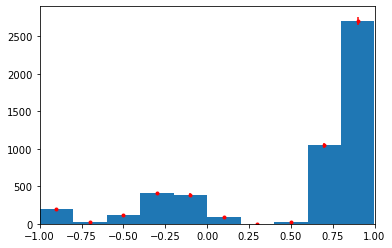

In [8]:
plot_dihedrals(dihedrals)

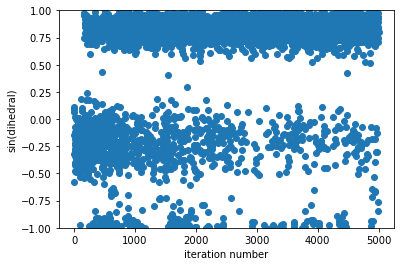

In [9]:
uncorrelated_new = plot_time_series(dihedrals, n_iter)


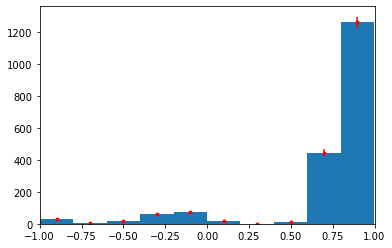

In [10]:
plot_dihedrals_uncorrelated(dihedrals, uncorrelated_new)

### ALA

In [15]:
pdb = app.PDBFile("/data/chodera/zhangi/perses_benchmark/neq/7/24/ala_vacuum.pdb")

In [16]:
for atom in pdb.topology.atoms():
    print(atom)

<Atom 0 (H1) of chain 0 residue 0 (ACE)>
<Atom 1 (CH3) of chain 0 residue 0 (ACE)>
<Atom 2 (H2) of chain 0 residue 0 (ACE)>
<Atom 3 (H3) of chain 0 residue 0 (ACE)>
<Atom 4 (C) of chain 0 residue 0 (ACE)>
<Atom 5 (O) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (ALA)>
<Atom 7 (H) of chain 0 residue 1 (ALA)>
<Atom 8 (CA) of chain 0 residue 1 (ALA)>
<Atom 9 (HA) of chain 0 residue 1 (ALA)>
<Atom 10 (CB) of chain 0 residue 1 (ALA)>
<Atom 11 (HB2) of chain 0 residue 1 (ALA)>
<Atom 12 (HB3) of chain 0 residue 1 (ALA)>
<Atom 13 (C) of chain 0 residue 1 (ALA)>
<Atom 14 (O) of chain 0 residue 1 (ALA)>
<Atom 15 (HB1) of chain 0 residue 1 (ALA)>
<Atom 16 (N) of chain 0 residue 2 (NME)>
<Atom 17 (H) of chain 0 residue 2 (NME)>
<Atom 18 (C) of chain 0 residue 2 (NME)>
<Atom 19 (H1) of chain 0 residue 2 (NME)>
<Atom 20 (H2) of chain 0 residue 2 (NME)>
<Atom 21 (H3) of chain 0 residue 2 (NME)>


In [14]:
i = 24
aa = 'ala' 
length = '5ns'
out_dir = f"/data/chodera/zhangi/perses_benchmark/neq/7/{i}/"

In [17]:
dihedrals_ala, n_iter = get_dihedrals(i, aa, length, out_dir, pdb.topology, [15, 10, 8, 6])

100%|██████████| 5001/5001 [00:04<00:00, 1150.47it/s]


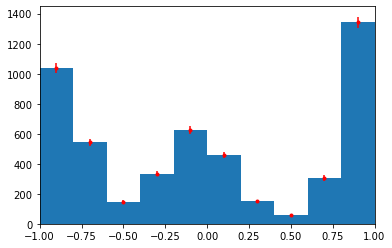

In [19]:
plot_dihedrals(dihedrals_ala)

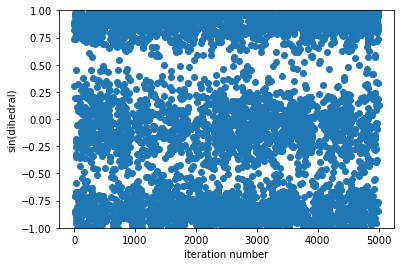

In [20]:
uncorrelated_new = plot_time_series(dihedrals_ala, n_iter)


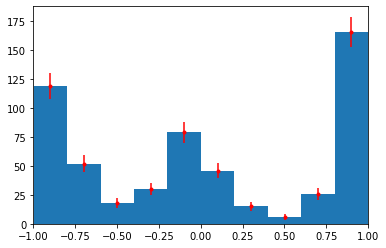

In [21]:
plot_dihedrals_uncorrelated(dihedrals_ala, uncorrelated_new)